# 陶瓷生产碳排放量预测模型

本笔记本使用 XGBoost 模型预测陶瓷企业的碳排放量，并提供了一个简单的交互式界面用于预测。

In [35]:
# 导入必要的库
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import ipywidgets as widgets
from IPython.display import display

# 导入自定义工具函数
from utils import CeramicsEmissions

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

## 1. 数据加载和预处理

In [36]:
# 加载陶瓷生产数据集
df = pd.read_csv("./datasets/陶瓷生产.csv")
df.head()

,企业,年份,化石燃料消耗量,低位发热量,二氧化碳排放因子,净购入电量,区域电网排放因子,化石燃料排放量,生产过程排放量,净购电排放量,碳排放量
0,东鹏陶瓷佛山建筑陶瓷厂,2022,"12,000 (天然气)",48.0,56.1,"850,000",0.60 (南方电网),"32,256","18,500","510,000","560,756"
1,马可波罗东莞瓷砖基地,2023,"15,500 (液化石油气)",46.3,63.1,"920,000",0.62 (南方电网),"45,120","22,300","570,400","637,820"
2,新明珠陶瓷肇庆工厂,2021,"28,000 (水煤气)",20.5,94.6,"1,200,000",0.65 (华南电网),"54,872","65,000","780,000","899,872"
3,蒙娜丽莎广西特种陶瓷,2022,"8,500 (天然气)",48.0,56.1,"480,000",0.58 (西南水电),"22,848","12,800","278,400","314,048"
4,诺贝尔陶瓷杭州工厂,2023,"9,800 (液化天然气)",48.0,56.1,"550,000",0.70 (华东电网),"26,544","15,200","385,000","426,744"


In [37]:
# 显示数据集基本信息
print(f"数据集形状: {df.shape}")
df.info()

数据集形状: (51, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   企业        51 non-null     object 
 1   年份        51 non-null     int64  
 2   化石燃料消耗量   51 non-null     object 
 3   低位发热量     49 non-null     float64
 4   二氧化碳排放因子  49 non-null     object 
 5   净购入电量     51 non-null     object 
 6   区域电网排放因子  51 non-null     object 
 7   化石燃料排放量   51 non-null     object 
 8   生产过程排放量   51 non-null     object 
 9   净购电排放量    51 non-null     object 
 10  碳排放量      51 non-null     object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.5+ KB


In [38]:
# 预处理函数：清除括号及括号内的内容
def clean_brackets(text):
    if isinstance(text, str):
        # 移除括号及其中的内容
        return re.sub(r"\(.*?\)", "", text).strip()
    return text


# 将逗号分隔的数字字符串转换为浮点数
def convert_to_float(text):
    if isinstance(text, str):
        # 先清除括号内容
        cleaned = clean_brackets(text)
        # 移除逗号后转换为浮点数
        return float(cleaned.replace(",", ""))
    return float(text)

In [39]:
# 应用预处理函数
# 创建数据的副本以避免警告
processed_df = df.copy()

# 处理数值列
numeric_cols = [
    "化石燃料消耗量",
    "低位发热量",
    "二氧化碳排放因子",
    "净购入电量",
    "区域电网排放因子",
    "化石燃料排放量",
    "生产过程排放量",
    "净购电排放量",
    "碳排放量",
]

for col in numeric_cols:
    processed_df[col] = processed_df[col].apply(convert_to_float)

# 查看预处理后的数据
processed_df.head()

,企业,年份,化石燃料消耗量,低位发热量,二氧化碳排放因子,净购入电量,区域电网排放因子,化石燃料排放量,生产过程排放量,净购电排放量,碳排放量
0,东鹏陶瓷佛山建筑陶瓷厂,2022,12000.0,48.0,56.1,850000.0,0.60,32256.0,18500.0,510000.0,560756.0
1,马可波罗东莞瓷砖基地,2023,15500.0,46.3,63.1,920000.0,0.62,45120.0,22300.0,570400.0,637820.0
2,新明珠陶瓷肇庆工厂,2021,28000.0,20.5,94.6,1200000.0,0.65,54872.0,65000.0,780000.0,899872.0
3,蒙娜丽莎广西特种陶瓷,2022,8500.0,48.0,56.1,480000.0,0.58,22848.0,12800.0,278400.0,314048.0
4,诺贝尔陶瓷杭州工厂,2023,9800.0,48.0,56.1,550000.0,0.70,26544.0,15200.0,385000.0,426744.0


## 2. 使用 utils.py 中的函数计算总排放量

In [40]:
# 使用 CeramicsEmissions 计算总排放量
def calculate_emissions(row):
    # 计算化石燃料排放
    fossil_fuel_emission = CeramicsEmissions.calculate_ceramics_fossil_fuel_emission(
        fossil_fuel_consumption=row["化石燃料消耗量"],
        low_heating_value=row["低位发热量"],
        co2_emission_factor=row["二氧化碳排放因子"],
    )

    # 计算净购电排放
    electricity_emission = (
        CeramicsEmissions.calculate_ceramics_purchased_electricity_emission(
            purchased_electricity=row["净购入电量"],
            regional_grid_emission_factor=row["区域电网排放因子"],
        )
    )

    # 生产过程排放直接从数据中获取
    process_emission = row["生产过程排放量"]

    # 计算总排放
    total_emission = CeramicsEmissions.calculate_ceramics_total_emission(
        fossil_fuel_emission=fossil_fuel_emission,
        process_emission=process_emission,
        purchased_electricity_emission=electricity_emission,
    )

    return {
        "calculated_fossil_fuel_emission": fossil_fuel_emission,
        "calculated_electricity_emission": electricity_emission,
        "calculated_total_emission": total_emission,
    }


# 应用计算函数并添加新列
emission_results = processed_df.apply(calculate_emissions, axis=1)
processed_df["计算_化石燃料排放"] = [
    result["calculated_fossil_fuel_emission"] for result in emission_results
]
processed_df["计算_电力排放"] = [
    result["calculated_electricity_emission"] for result in emission_results
]
processed_df["计算_总排放量"] = [
    result["calculated_total_emission"] for result in emission_results
]

化石燃料排放量 - 原始值 vs 计算值的相关性： nan
净购电排放量 - 原始值 vs 计算值的相关性： 1.0
总碳排放量 - 原始值 vs 计算值的相关性： nan


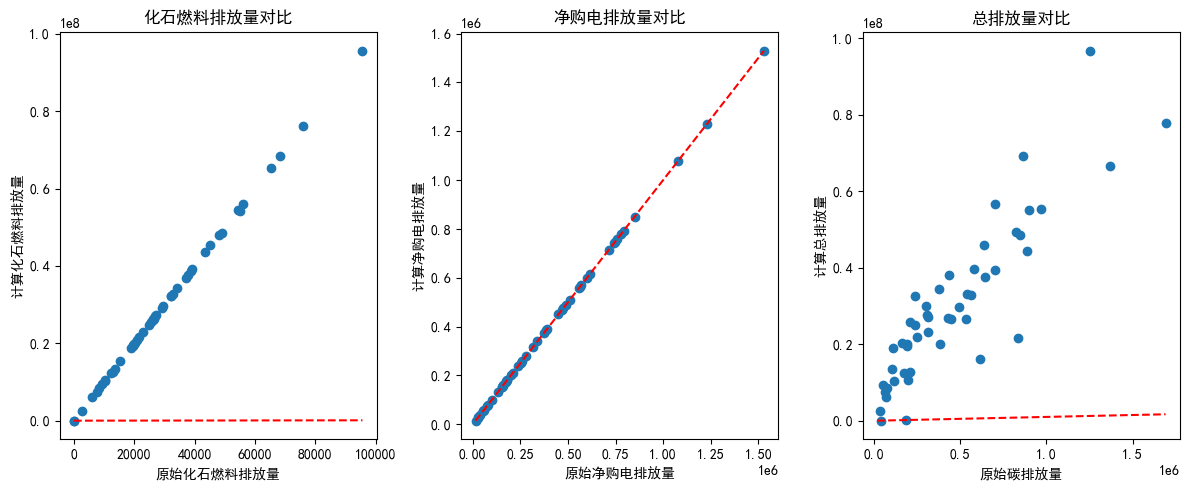

In [41]:
# 比较计算值与原始数据中的值
print(
    "化石燃料排放量 - 原始值 vs 计算值的相关性：",
    np.corrcoef(processed_df["化石燃料排放量"], processed_df["计算_化石燃料排放"])[
        0, 1
    ],
)
print(
    "净购电排放量 - 原始值 vs 计算值的相关性：",
    np.corrcoef(processed_df["净购电排放量"], processed_df["计算_电力排放"])[0, 1],
)
print(
    "总碳排放量 - 原始值 vs 计算值的相关性：",
    np.corrcoef(processed_df["碳排放量"], processed_df["计算_总排放量"])[0, 1],
)

# 绘制对比图
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.scatter(processed_df["化石燃料排放量"], processed_df["计算_化石燃料排放"])
plt.xlabel("原始化石燃料排放量")
plt.ylabel("计算化石燃料排放量")
plt.title("化石燃料排放量对比")
plt.plot(
    [processed_df["化石燃料排放量"].min(), processed_df["化石燃料排放量"].max()],
    [processed_df["化石燃料排放量"].min(), processed_df["化石燃料排放量"].max()],
    "r--",
)

plt.subplot(1, 3, 2)
plt.scatter(processed_df["净购电排放量"], processed_df["计算_电力排放"])
plt.xlabel("原始净购电排放量")
plt.ylabel("计算净购电排放量")
plt.title("净购电排放量对比")
plt.plot(
    [processed_df["净购电排放量"].min(), processed_df["净购电排放量"].max()],
    [processed_df["净购电排放量"].min(), processed_df["净购电排放量"].max()],
    "r--",
)

plt.subplot(1, 3, 3)
plt.scatter(processed_df["碳排放量"], processed_df["计算_总排放量"])
plt.xlabel("原始碳排放量")
plt.ylabel("计算总排放量")
plt.title("总排放量对比")
plt.plot(
    [processed_df["碳排放量"].min(), processed_df["碳排放量"].max()],
    [processed_df["碳排放量"].min(), processed_df["碳排放量"].max()],
    "r--",
)

plt.tight_layout()
plt.show()

## 3. 特征工程与模型构建

In [42]:
# 选择特征和目标变量
features = [
    "化石燃料消耗量",
    "低位发热量",
    "二氧化碳排放因子",
    "净购入电量",
    "区域电网排放因子",
    "生产过程排放量",
    "计算_总排放量",
]
X = processed_df[features]
y = processed_df["碳排放量"]

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# 创建XGBoost回归模型
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

# 训练模型
xgb_model.fit(X_train_scaled, y_train)

# 预测测试集
y_pred = xgb_model.predict(X_test_scaled)

In [44]:
# 评估模型性能
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方根误差 (RMSE): {rmse:.2f}")
print(f"平均绝对误差 (MAE): {mae:.2f}")
print(f"决定系数 (R²): {r2:.4f}")

均方根误差 (RMSE): 66583.59
平均绝对误差 (MAE): 43970.35
决定系数 (R²): 0.9422


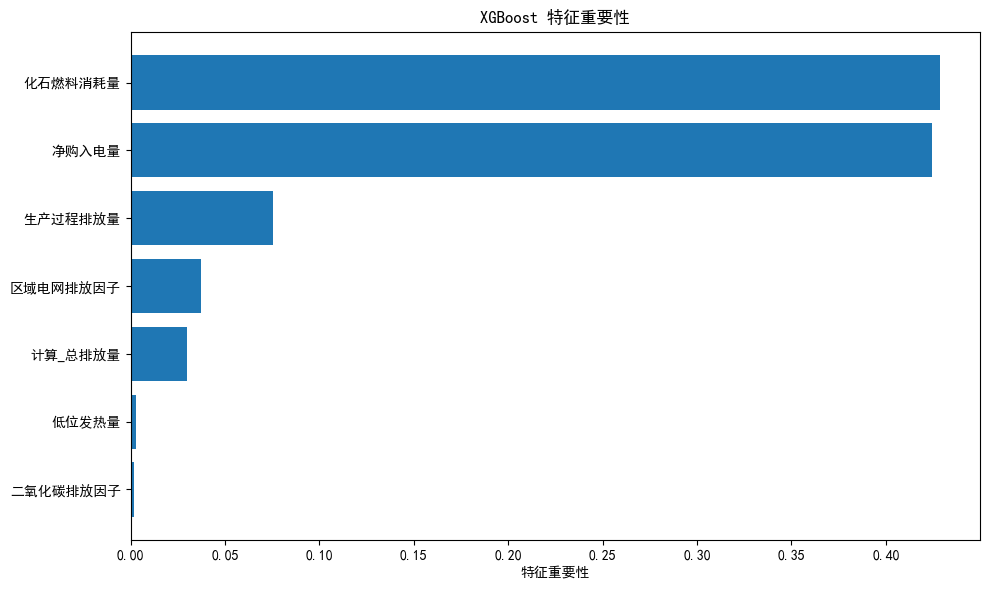

In [45]:
# 特征重要性可视化
plt.figure(figsize=(10, 6))
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("特征重要性")
plt.title("XGBoost 特征重要性")
plt.tight_layout()
plt.show()

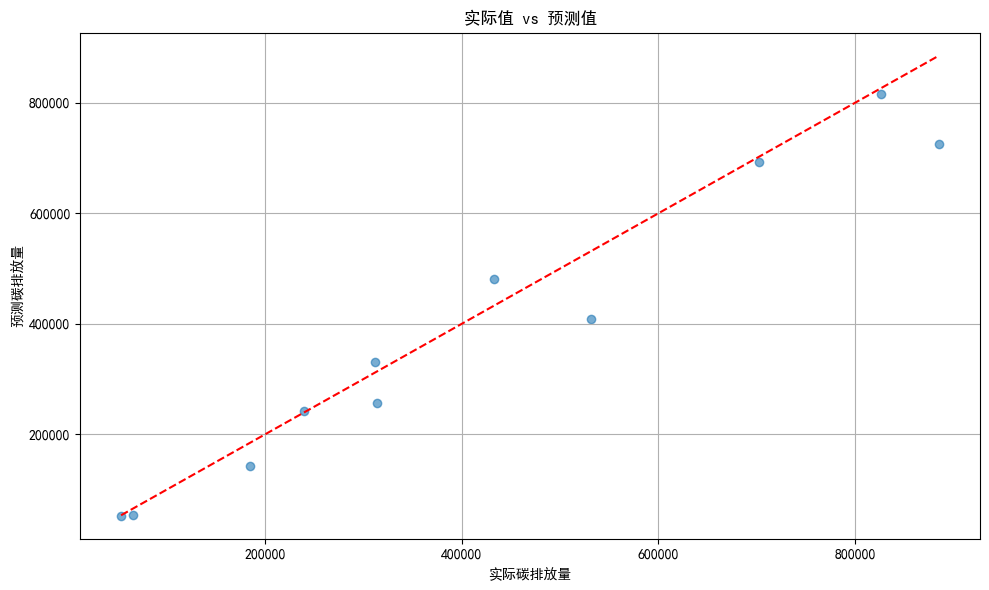

In [46]:
# 实际值与预测值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("实际碳排放量")
plt.ylabel("预测碳排放量")
plt.title("实际值 vs 预测值")
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. 创建交互式GUI界面

In [47]:
# 创建用户输入的GUI界面
def predict_emission(change):
    # 获取用户输入的值
    fossil_fuel = float(fossil_fuel_input.value)
    heating_value = float(heating_value_input.value)
    emission_factor = float(emission_factor_input.value)
    electricity = float(electricity_input.value)
    grid_factor = float(grid_factor_input.value)
    process_emission = float(process_emission_input.value)

    # 计算总排放量
    fossil_emission = CeramicsEmissions.calculate_ceramics_fossil_fuel_emission(
        fossil_fuel_consumption=fossil_fuel,
        low_heating_value=heating_value,
        co2_emission_factor=emission_factor,
    )
    electricity_emission = (
        CeramicsEmissions.calculate_ceramics_purchased_electricity_emission(
            purchased_electricity=electricity, regional_grid_emission_factor=grid_factor
        )
    )
    total_calculated = CeramicsEmissions.calculate_ceramics_total_emission(
        fossil_fuel_emission=fossil_emission,
        process_emission=process_emission,
        purchased_electricity_emission=electricity_emission,
    )

    # 创建输入数据
    input_data = np.array(
        [
            [
                fossil_fuel,
                heating_value,
                emission_factor,
                electricity,
                grid_factor,
                process_emission,
                total_calculated,
            ]
        ]
    )

    # 标准化输入数据
    input_scaled = scaler.transform(input_data)

    # 预测
    prediction = xgb_model.predict(input_scaled)[0]

    # 更新结果输出
    fossil_emission_output.value = f"化石燃料排放: {fossil_emission:.2f} 吨CO2"
    electricity_emission_output.value = f"电力排放: {electricity_emission:.2f} 吨CO2"
    process_emission_output.value = f"过程排放: {process_emission:.2f} 吨CO2"
    calculated_total_output.value = f"计算总排放: {total_calculated:.2f} 吨CO2"
    predicted_output.value = f"预测碳排放量: {prediction:.2f} 吨CO2"


# 创建输入部件
style = {"description_width": "150px"}
layout = widgets.Layout(width="500px")

fossil_fuel_input = widgets.Text(
    value="10000", description="化石燃料消耗量:", style=style, layout=layout
)

heating_value_input = widgets.Text(
    value="48", description="低位发热量:", style=style, layout=layout
)

emission_factor_input = widgets.Text(
    value="56.1", description="二氧化碳排放因子:", style=style, layout=layout
)

electricity_input = widgets.Text(
    value="500000", description="净购入电量:", style=style, layout=layout
)

grid_factor_input = widgets.Text(
    value="0.60", description="区域电网排放因子:", style=style, layout=layout
)

process_emission_input = widgets.Text(
    value="20000", description="生产过程排放量:", style=style, layout=layout
)

calculate_button = widgets.Button(
    description="计算预测排放量",
    button_style="primary",
    layout=widgets.Layout(width="200px"),
)

# 创建输出部件
fossil_emission_output = widgets.HTML(value="化石燃料排放: 0.00 吨CO2")
electricity_emission_output = widgets.HTML(value="电力排放: 0.00 吨CO2")
process_emission_output = widgets.HTML(value="过程排放: 0.00 吨CO2")
calculated_total_output = widgets.HTML(value="计算总排放: 0.00 吨CO2")
predicted_output = widgets.HTML(value="预测碳排放量: 0.00 吨CO2")

# 添加按钮点击事件
calculate_button.on_click(predict_emission)

# 创建界面布局
input_box = widgets.VBox(
    [
        fossil_fuel_input,
        heating_value_input,
        emission_factor_input,
        electricity_input,
        grid_factor_input,
        process_emission_input,
        calculate_button,
    ]
)

output_box = widgets.VBox(
    [
        widgets.HTML(value="<b>计算结果:</b>"),
        fossil_emission_output,
        electricity_emission_output,
        process_emission_output,
        calculated_total_output,
        widgets.HTML(value="<br><b>模型预测:</b>"),
        predicted_output,
    ]
)

# 显示界面
display(widgets.HTML(value="<h3>陶瓷生产企业碳排放预测工具</h3>"))
display(widgets.HTML(value="<p>请输入以下参数进行碳排放量预测：</p>"))
display(widgets.HBox([input_box, output_box]))

HTML(value='<h3>陶瓷生产企业碳排放预测工具</h3>')

HTML(value='<p>请输入以下参数进行碳排放量预测：</p>')

## 5. 保存模型

In [48]:
# # 保存模型
# import joblib

# # 保存XGBoost模型
# joblib.dump(xgb_model, './ceramics_emission_model.pkl')

# # 保存标准化器
# joblib.dump(scaler, './ceramics_scaler.pkl')

# print("模型和标准化器已保存。")

## 6. 总结

在这个项目中，我们：

1. 对陶瓷生产数据集进行了预处理，包括去除括号内容和转换数值格式
2. 使用 utils.py 中的 CeramicsEmissions 类计算了排放量
3. 构建了 XGBoost 模型预测碳排放量
4. 评估了模型性能并可视化了结果
5. 创建了一个简单的交互式界面供用户输入参数预测碳排放量

这个模型可以帮助陶瓷企业预测其生产活动的碳排放量，从而更好地进行碳管理和减排规划。